In [1]:
import pandas as pd, numpy as np
from sklearn.linear_model import LinearRegression
import cvxportfolio as cvx
from typing import Dict, List
import yfinance as yf
from scipy.stats.mstats import winsorize
from typing import List
from tqdm import tqdm
from sklearn.pipeline import Pipeline


def xsec_z(df: pd.DataFrame) -> pd.DataFrame:
    """Cross-sectional z-score by date."""
    m, s = df.mean(1), df.std(1).replace(0, 1)
    return df.sub(m, 0).div(s, 0)

def cs_demean(df: pd.DataFrame) -> pd.DataFrame:
    """Cross-sectional demean by date."""
    return df.sub(df.mean(1), 0)

def make_panel(features: Dict[str, pd.DataFrame], target: pd.DataFrame) -> pd.DataFrame:
    """Wide (date×asset) → long panel with features + target."""
    X = pd.concat(features, axis=1)  # MultiIndex columns: (feat, asset)
    X = X.stack().rename_axis(['date','asset']).reset_index()
    Y = target.stack().rename('y').reset_index()
    Y.columns = ['date','asset','y']
    return X.merge(Y, on=['date','asset']).dropna()


assets = \
    ['AAPL', 'ABNB', 'ADBE', 'ADI', 'ADP', 'ADSK', 'AEP', 'AMAT', 'AMD', 'AMGN',
    'AMZN', 'APP', 'ARM', 'ASML', 'AVGO', 'AXON', 'AZN', 'BIIB', 'BKNG', 'BKR',
    'CCEP', 'CDNS', 'CDW', 'CEG', 'CHTR', 'CMCSA', 'COST', 'CPRT', 'CRWD', 'CSCO',
    'CSGP', 'CSX', 'CTAS', 'CTSH', 'DASH', 'DDOG', 'DXCM', 'EA', 'EXC', 'FANG',
    'FAST', 'FTNT', 'GEHC', 'GFS', 'GILD', 'GOOG', 'GOOGL', 'HON', 'IDXX', 'INTC',
    'INTU', 'ISRG', 'KDP', 'KHC', 'KLAC', 'LIN', 'LRCX', 'LULU', 'MAR', 'MCHP',
    'MDLZ', 'MELI', 'META', 'MNST', 'MRVL', 'MSFT', 'MSTR', 'MU', 'NFLX', 'NVDA',
    'NXPI', 'ODFL', 'ON', 'ORLY', 'PANW', 'PAYX', 'PCAR', 'PDD', 'PEP', 'PLTR',
    'PYPL', 'QCOM', 'REGN', 'ROP', 'ROST', 'SBUX', 'SHOP', 'SNPS', 'TEAM', 'TMUS',
    'TRI', 'TSLA', 'TTD', 'TTWO', 'TXN', 'VRSK', 'VRTX', 'WBD', 'WDAY', 'XEL',
    'ZS']

high_missings = [
    'ARM',
    'GEHC',
    'CEG',
    'GFS',
    'APP',
    'ABNB',
    'DASH',
    'PLTR',
    'DDOG',
    'CRWD',
    'PDD',
    'ZS',
    'TTD',
    'TEAM',
    'KHC',
    'PYPL',
    'SHOP',
]

assets = list(set(assets) - set(high_missings))

# Try loading from cached CSV first
try:
    data = pd.read_csv('hf_evolution_data.csv', header=[0,1], index_col=0, parse_dates=True)
    prices = data['Close'].dropna(how='all')
except FileNotFoundError:
    # Prices (Adj Close)
    data = yf.download(assets, start="2015-01-01", group_by='column', progress=False)
    data.to_csv('hf_evolution_data.csv')  # cache for next time

prices = data['Close'].dropna(how='all')

# Example price-only signals:
mom = prices.pct_change(60)             # 3m momentum (approx)
rev = -prices.pct_change(5)             # 1w reversal proxy
qual = -prices.pct_change().rolling(60).std()  # "quality" proxy = low vol

# Map to your earlier variable names (so slides run unchanged)
btp  = (prices.rolling(252).mean() / prices)  # crude "value" proxy
roa  = qual

val  = btp[assets]  # value
qual = roa[assets]  # quality
rev  = rev[assets]  # reversal

# Cross-sectional z-scoring
mom_z, val_z, qual_z, rev_z = map(xsec_z, [mom, val, qual, rev])

# We have daily data; target = forward 5d return, demeaned
# First, rolling cumulative return over next 5 days
r5 = prices[assets].pct_change().rolling(5).sum().shift(-5)
y_cs = cs_demean(r5)

# Index alignment (avoid silent misalignment)
idx = (mom_z.index
  .intersection(val_z.index)
  .intersection(qual_z.index)
  .intersection(rev_z.index)
  .intersection(y_cs.index))

mom_z, val_z, qual_z, rev_z, y_cs = \
  mom_z.loc[idx], val_z.loc[idx], qual_z.loc[idx], rev_z.loc[idx], y_cs.loc[idx]

# Feature dict (single source of truth for names/order)
FEATS = {'mom': mom_z, 'val': val_z, 'qual': qual_z, 'rev': rev_z}

# Winsorize features (5th–95th percentile per date)
for k in FEATS:
    FEATS[k] = FEATS[k].apply(lambda row:
        pd.Series(winsorize(row, limits=[0.05, 0.05]), index=row.index),
        axis=1
    )

panel = make_panel(FEATS, y_cs)
qtiles = panel.copy()

factors = ["mom", "val", "qual", "rev"]

# Apply quintile assignment per day for each factor
for f in factors:
    qtiles[f"{f}_q"] = panel.groupby("date")[f].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates="drop") + 1
    )

# Factors with quintiles
q_factors = ["mom_q", "val_q", "qual_q", "rev_q"]

avg_returns = {}
for q in q_factors:
    avg_returns[q] = qtiles.groupby(q)["y"].mean()

# Put into a dataframe for easier comparison
avg_returns_df = pd.DataFrame(avg_returns)

print("Average Returns by Quintile:")
print(avg_returns_df)



/tmp/ipykernel_628074/302306455.py:77: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  mom = prices.pct_change(60)             # 3m momentum (approx)
/tmp/ipykernel_628074/302306455.py:78: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  rev = -prices.pct_change(5)             # 1w reversal proxy
/tmp/ipykernel_628074/302306455.py:79: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  qual = -prices.p

Average Returns by Quintile:
      mom_q     val_q    qual_q     rev_q
1  0.001171  0.000279  0.002264 -0.000453
2  0.000358 -0.000460  0.000264 -0.000836
3 -0.000627 -0.000546 -0.000610 -0.000283
4 -0.001200 -0.000372 -0.000523  0.000273
5  0.000262  0.001068 -0.001431  0.001282


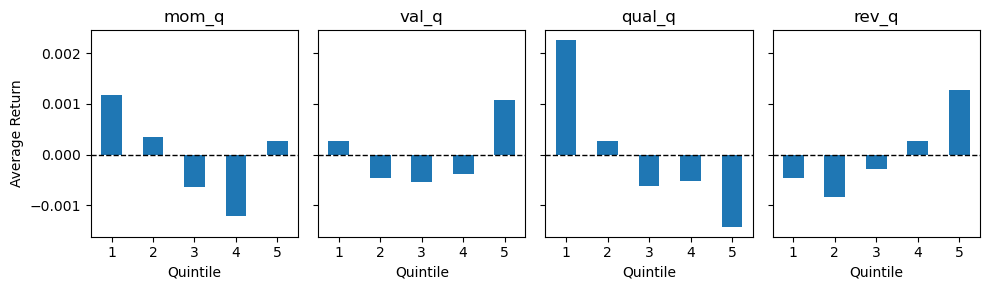

In [2]:
# for each column in avg_returns_df, make a bar plot with title "Average Returns by Quintile for {column name}"
# should be on 4x4 grid

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 4, figsize=(10, 3), sharey=True)
axes = axes.flatten()

for i, col in enumerate(avg_returns_df.columns):
    avg_returns_df[col].plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{col}")
    axes[i].set_xlabel("Quintile")
    if i == 0:  # only put ylabel on first axis to avoid clutter
        axes[i].set_ylabel("Average Return")
    axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=0)
    
    # add dashed horizontal line at y=0
    axes[i].axhline(0, color="black", linestyle="--", linewidth=1)

plt.tight_layout()
plt.savefig("./images/avg_returns_by_quintile.png", dpi=300)
plt.show()



In [3]:
import numpy as np
import pandas as pd
from typing import List, Optional
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge

class GroupwiseQuantileBinner(BaseEstimator, TransformerMixin):
    """
    Bin specified columns into q quantiles *within each group* (e.g., each date).
    Returns a DataFrame with one integer-coded bin column per input column: col+'_q'.
    """
    def __init__(self, group_col: str, cols: List[str], q: int = 5, labels_start: int = 1):
        self.group_col = group_col
        self.cols = cols
        self.q = q
        self.labels_start = labels_start

    def fit(self, X, y=None):
        # No learned state; bins computed on-the-fly per group during transform
        return self

    def _bin_series(self, s: pd.Series) -> pd.Series:
        # Use rank to avoid qcut "duplicates" issues; then qcut on ranks per group
        r = s.rank(method="first")  # strictly increasing within ties
        b = pd.qcut(r, self.q, labels=False, duplicates="drop")
        # Convert to 1..k (k<=q) integers; if group too small -> NaNs remain
        return (b + self.labels_start) if b is not None else pd.Series(np.nan, index=s.index)

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.cols + [self.group_col] if hasattr(self, "cols") else None)

        if self.group_col not in X.columns:
            raise KeyError(f"Group column '{self.group_col}' not found in X")

        out = {}
        g = X.groupby(self.group_col, sort=False)
        for c in self.cols:
            if c not in X.columns:
                raise KeyError(f"Column '{c}' not found in X")
            # apply per group
            out[f"{c}_q"] = g[c].transform(self._bin_series)
        return pd.DataFrame(out, index=X.index)

# ----- configure columns -----
factor_cols = ['mom', 'val', 'qual', 'rev']              # put all your factor names here
group_col = "date"

# ----- preprocessing -----
# 1) passthrough original numeric factors
# 2) build per-date quintile labels and one-hot encode
pre = ColumnTransformer(
    transformers=[
        ("num", "passthrough", factor_cols),
        ("qtile",
         Pipeline(steps=[
             ("bin", GroupwiseQuantileBinner(group_col=group_col, cols=factor_cols, q=5)),
             ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"))
         ]),
         [group_col] + factor_cols),
    ],
    remainder="drop"
)

# ----- full pipeline -----
# PolynomialFeatures over the *concatenated* numeric + dummies → gives squares and all interactions
pipe = Pipeline(steps=[
    ("prep", pre),
    ("poly", PolynomialFeatures(degree=2, include_bias=False, interaction_only=False)),
    ("reg", Ridge(alpha=1.0))
])

pipe

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['mom', 'val', 'qual',
                                                   'rev']),
                                                 ('qtile',
                                                  Pipeline(steps=[('bin',
                                                                   GroupwiseQuantileBinner(cols=['mom',
                                                                                                 'val',
                                                                                                 'qual',
                                                                                                 'rev'],
                                                                                           group_col='date')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'))]),
                                                  ['date', 'mom', 'val', 'qual',
                                                   'rev'])])),
                ('poly', PolynomialFeatures(include_bias=False)),
                ('reg', Ridge())])

In [4]:
def walk_forward_oof_blocks(model: Pipeline,
                            panel: pd.DataFrame,
                            feature_cols: List[str],
                            assets: List[str],
                            warm: int = 60,
                            inc: int = 60,
                            fill_missing: Optional[float] = None) -> pd.DataFrame:
    if inc < 1:
        raise ValueError("inc must be >= 1")

    # Ensure datetime dtype
    if not np.issubdtype(panel['date'].dtype, np.datetime64):
        panel = panel.copy()
        panel['date'] = pd.to_datetime(panel['date'])

    # Sort dates
    dates = np.sort(panel['date'].unique())
    n = len(dates)

    alpha = pd.DataFrame(index=dates, columns=assets, dtype=float)

    if n <= max(warm, 1):
        return alpha.fillna(fill_missing) if fill_missing is not None else alpha

    # Check required columns exist (include group_col/date!)
    required = ['date'] + feature_cols + ['y']
    missing = [c for c in required if c not in panel.columns]
    if missing:
        raise KeyError(f"Missing columns in panel: {missing}")

    needed_for_X = ['date'] + feature_cols

    for k in tqdm(range(warm, n, inc)):
        t_start = dates[k]
        t_end_idx = min(k + inc, n)
        pred_block_dates = dates[k:t_end_idx]

        # Expanding train set
        train = panel[panel['date'] < t_start]
        if train.empty:
            continue

        # Mask for valid training rows (complete features + target)
        trainX = train[needed_for_X]
        trainy = train['y']
        good = train[feature_cols].notna().all(axis=1) & trainy.notna()
        if not good.any():
            continue

        # >>> main fix: pass date + features, indexed by the boolean mask
        model.fit(trainX.loc[good], trainy.loc[good])

        # Block to predict
        block = panel[panel['date'].isin(pred_block_dates)]
        if block.empty:
            continue

        blockX = block[needed_for_X]
        ok = block[feature_cols].notna().all(axis=1)
        if not ok.any():
            continue

        preds = model.predict(blockX.loc[ok])

        tmp = block.loc[ok, ['date', 'asset']].copy()
        tmp['pred'] = preds

        block_alpha = tmp.pivot_table(index='date', columns='asset', values='pred', aggfunc='mean')
        block_alpha = block_alpha.reindex(index=pred_block_dates, columns=assets)

        alpha.loc[block_alpha.index, block_alpha.columns] = block_alpha

    if fill_missing is not None:
        alpha = alpha.fillna(fill_missing)

    return alpha


In [5]:
panel.head()

,date,asset,mom,val,qual,rev,y
20664,2015-12-31,AAPL,-0.764311,0.881718,0.407499,1.564991,-0.007894
20665,2015-12-31,ADBE,0.390397,-0.919679,0.403154,0.038777,0.006430
20666,2015-12-31,ADI,-0.545710,0.426180,-0.284656,0.875700,-0.027258
20667,2015-12-31,ADP,-0.130229,-0.113702,1.116678,0.289959,-0.007092
20668,2015-12-31,ADSK,1.550764,-0.523511,-0.570226,0.698689,-0.026353


In [6]:
panel.head()

,date,asset,mom,val,qual,rev,y
20664,2015-12-31,AAPL,-0.764311,0.881718,0.407499,1.564991,-0.007894
20665,2015-12-31,ADBE,0.390397,-0.919679,0.403154,0.038777,0.006430
20666,2015-12-31,ADI,-0.545710,0.426180,-0.284656,0.875700,-0.027258
20667,2015-12-31,ADP,-0.130229,-0.113702,1.116678,0.289959,-0.007092
20668,2015-12-31,ADSK,1.550764,-0.523511,-0.570226,0.698689,-0.026353


In [7]:
%%time
# Try loading from cached CSV first
try:
    alpha = pd.read_csv('hf_evolution_alpha.csv', index_col=0, parse_dates=True)
except FileNotFoundError:
    alpha = walk_forward_oof_blocks(pipe, panel, list(FEATS.keys()), assets, warm=60)
    alpha = alpha.reset_index().rename(columns={"index": "date"}).dropna()
    alpha.to_csv("hf_evolution_alpha.csv", index=False)

CPU times: user 28.7 ms, sys: 11.6 ms, total: 40.4 ms
Wall time: 39.5 ms


In [8]:
alpha.head()


,CSCO,ROP,MAR,MRVL,EXC,ADBE,MNST,WBD,TXN,XEL,...,LIN,ADP,CDW,AAPL,ISRG,NVDA,KLAC,FTNT,AMZN,LULU
date,,,,,,,,,,,,,,,,,,,,,
2016-03-30,-0.002026,0.000451,0.006010,-0.000910,0.007078,0.003679,0.019936,-0.013853,0.002350,-0.004420,...,0.008070,0.007922,0.001624,-0.036775,-0.001036,-0.003007,0.000953,0.015200,0.005435,-0.008062
2016-03-31,-0.007468,-0.000477,0.005322,-0.022605,0.008112,0.003735,0.021272,-0.016911,-0.009836,-0.002729,...,0.004857,0.005211,-0.002196,-0.003475,-0.016045,-0.013311,-0.000008,0.013308,0.005749,-0.004853
2016-04-01,-0.006204,-0.000968,-0.007296,-0.006442,0.015863,0.003357,0.013831,-0.019064,-0.012524,-0.004144,...,0.012494,0.004065,-0.002284,-0.001179,-0.013374,-0.013183,-0.000789,0.017159,-0.004737,-0.006735
2016-04-04,-0.004536,0.011523,-0.007253,-0.005093,0.012912,0.003380,0.019236,-0.017584,-0.008439,-0.005945,...,0.001698,0.005114,-0.000341,0.014901,-0.014055,-0.020007,-0.018312,0.026954,-0.008960,-0.004806
2016-04-05,0.001891,-0.003778,-0.016738,-0.018917,-0.004192,0.004851,0.000722,-0.014705,-0.004724,0.002418,...,0.009656,-0.006680,-0.000324,0.013272,-0.010833,-0.016852,0.014583,0.027885,0.010715,-0.007487


In [10]:
alpha = (alpha
 .stack()
 .to_frame('alpha')
 .reset_index()
 .rename(columns={'level_1': 'asset'}))

In [11]:
alpha_q = alpha.copy()
alpha_q['y'] = panel.set_index(['date', 'asset']).loc[alpha.set_index(['date', 'asset']).index, 'y'].values

alpha_q[f"alpha_q"] = alpha_q.groupby("date")["alpha"].transform(
        lambda x: pd.qcut(x, 5, labels=False, duplicates="drop") + 1
    )

qtiles = alpha_q.groupby('alpha_q')["y"].mean()

# # Put into a dataframe for easier comparison
# avg_returns_df = pd.DataFrame(avg_returns)

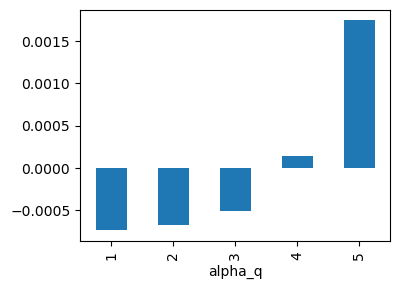

In [12]:
qtiles.plot(kind='bar', figsize=(4,3));

In [13]:
df_unstacked = alpha.set_index(['date', 'asset']).unstack()
df_unstacked.columns = df_unstacked.columns.droplevel(0)  # drop first level of columns MultiIndex
df_unstacked.head()

asset,AAPL,ADBE,ADI,ADP,ADSK,AEP,AMAT,AMD,AMGN,AMZN,...,TMUS,TRI,TSLA,TTWO,TXN,VRSK,VRTX,WBD,WDAY,XEL
date,,,,,,,,,,,,,,,,,,,,,
2016-03-30,-0.036775,0.003679,0.005505,0.007922,0.017491,-0.004905,-0.011015,0.016507,0.003342,0.005435,...,0.002434,-0.006052,0.004799,0.001206,0.002350,0.001267,0.005754,-0.013853,0.028334,-0.004420
2016-03-31,-0.003475,0.003735,0.001667,0.005211,0.021576,-0.000831,-0.013355,0.020204,0.005131,0.005749,...,-0.010180,-0.004565,-0.000627,0.001474,-0.009836,0.014883,0.006159,-0.016911,0.029677,-0.002729
2016-04-01,-0.001179,0.003357,0.006717,0.004065,0.027640,-0.001426,-0.014237,0.024647,-0.000284,-0.004737,...,0.003266,-0.007064,-0.000357,0.000822,-0.012524,0.011318,0.005195,-0.019064,0.028215,-0.004144
2016-04-04,0.014901,0.003380,0.011288,0.005114,0.018466,-0.002380,-0.010650,-0.012186,0.013321,-0.008960,...,-0.003183,0.001231,0.010380,-0.002165,-0.008439,0.000294,0.003914,-0.017584,0.024587,-0.005945
2016-04-05,0.013272,0.004851,0.002176,-0.006680,0.020291,0.009040,-0.009988,-0.036877,0.008253,0.010715,...,-0.003578,-0.006215,-0.012969,0.009558,-0.004724,0.000946,0.007964,-0.014705,0.022329,0.002418


In [14]:
class ReturnsFromDF:
    """
                                AAPL  AMZN  GOOG  MSFT  USDOLLAR
    1980-12-12 14:30:00+00:00 -0.047823   NaN   NaN   NaN  0.000705
    1980-12-15 14:30:00+00:00 -0.073063   NaN   NaN   NaN  0.000711
    1980-12-16 14:30:00+00:00  0.019703   NaN   NaN   NaN  0.000739
    1980-12-17 14:30:00+00:00  0.028993   NaN   NaN   NaN  0.000733
    1980-12-18 14:30:00+00:00  0.061029   NaN   NaN   NaN  0.000748


    returns
    AAPL    0.002740
    AMZN    0.001084
    GOOG    0.001192
    MSFT    0.001979
    dtype: float64
    """
    def __init__(self, df: pd.DataFrame): self.df = df

    def values_in_time(self, past_returns, **kwargs):
        #if t not in self.df.index:
        #    return pd.Series(0.0, index=self.df.columns, dtype=float)
        last_returns_date = past_returns.index.max()
        return self.df[:last_returns_date].iloc[-1]


In [15]:

start = str(df_unstacked.index.min().date()) if len(df_unstacked.index) else '2020-01-01'
sim = cvx.StockMarketSimulator(assets, trading_frequency='weekly')


Updating data...............

YahooFinance("BIIB") has dubious total open-to-open returns for timestamps: DatetimeIndex(['2005-02-25 14:30:00+00:00'], dtype='datetime64[ns, UTC]', freq=None)


.....................................................................


In [ ]:
# df = df_unstacked.copy()
# df.index = pd.to_datetime(df.index).normalize()
df = df_unstacked.copy()
df = df.rolling(window=5).mean()  # smooth a bit

rf = ReturnsFromDF(df)
gamma = 1.5
kappa = 0.05

obj = (cvx.ReturnsForecast(rf)
  - gamma * (cvx.FactorModelCovariance(num_factors=4))
)

constraints = [
    cvx.LeverageLimit(4),
    cvx.MarketNeutral(),
    cvx.DollarNeutral(),
    cvx.MaxWeights(0.05),
    cvx.MinWeights(-0.05),
]

policy = cvx.SinglePeriodOptimization(obj, constraints)


In [17]:
%%time
results = sim.backtest_many(
    [policy, cvx.Uniform()], start_time='2017-01-01')


CPU times: user 10.8 ms, sys: 43.7 ms, total: 54.5 ms
Wall time: 16.3 s


In [18]:
results[0].sharpe_ratio, results[1].sharpe_ratio

(np.float64(-0.04284374866842475), np.float64(1.0605894486645435))

In [19]:
results[0].annualized_average_return, results[1].annualized_average_return

(np.float64(0.01678319454501576), np.float64(0.23033169690872216))

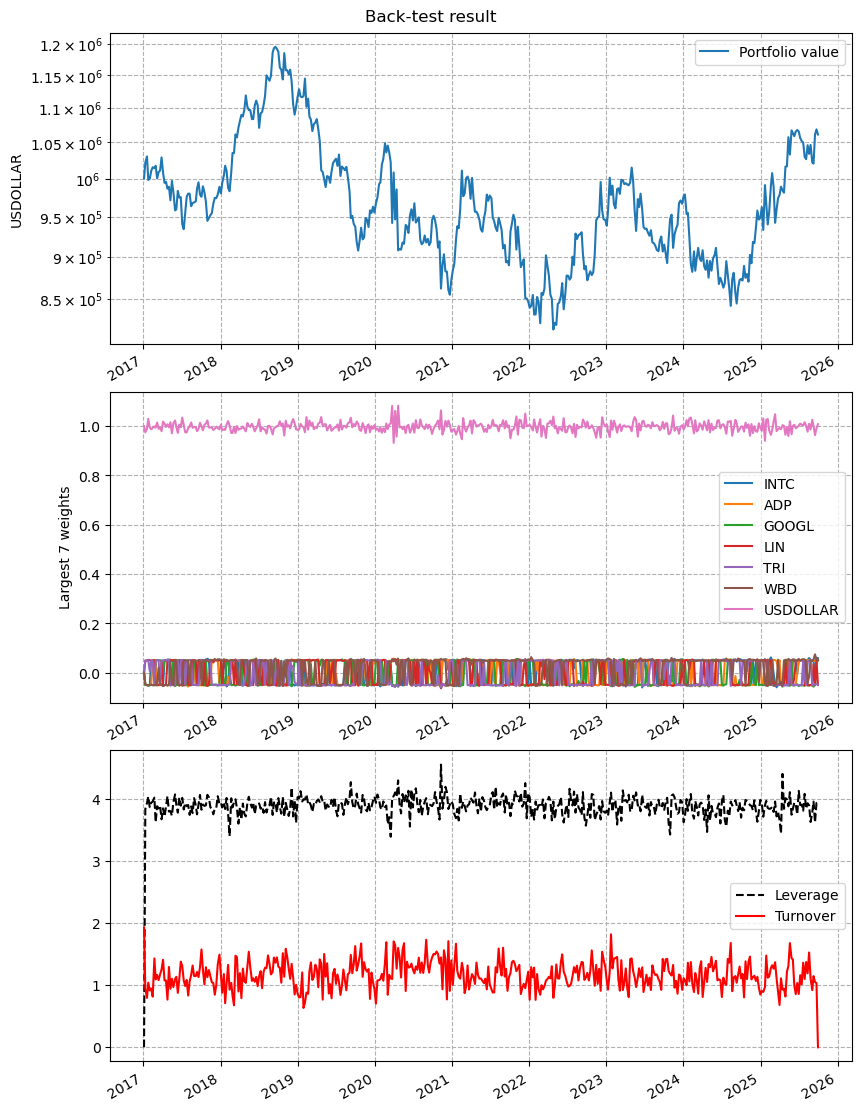

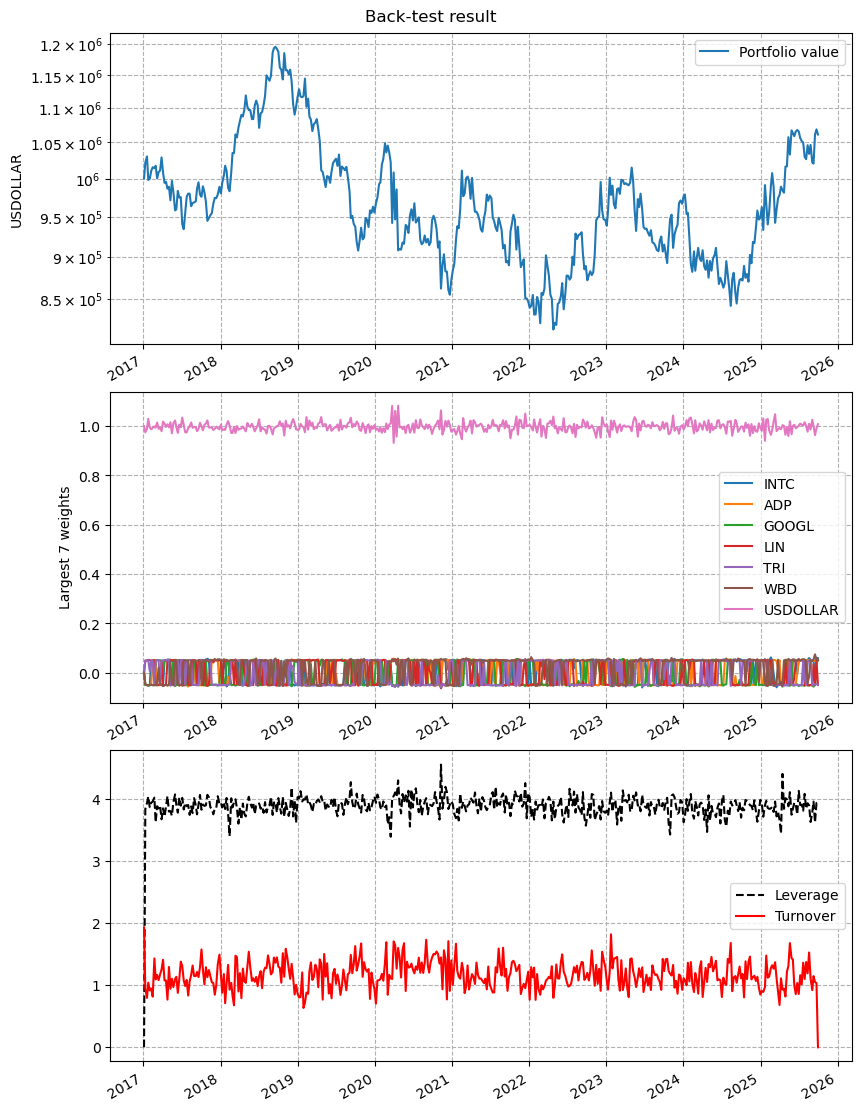

In [20]:
results[0].plot()

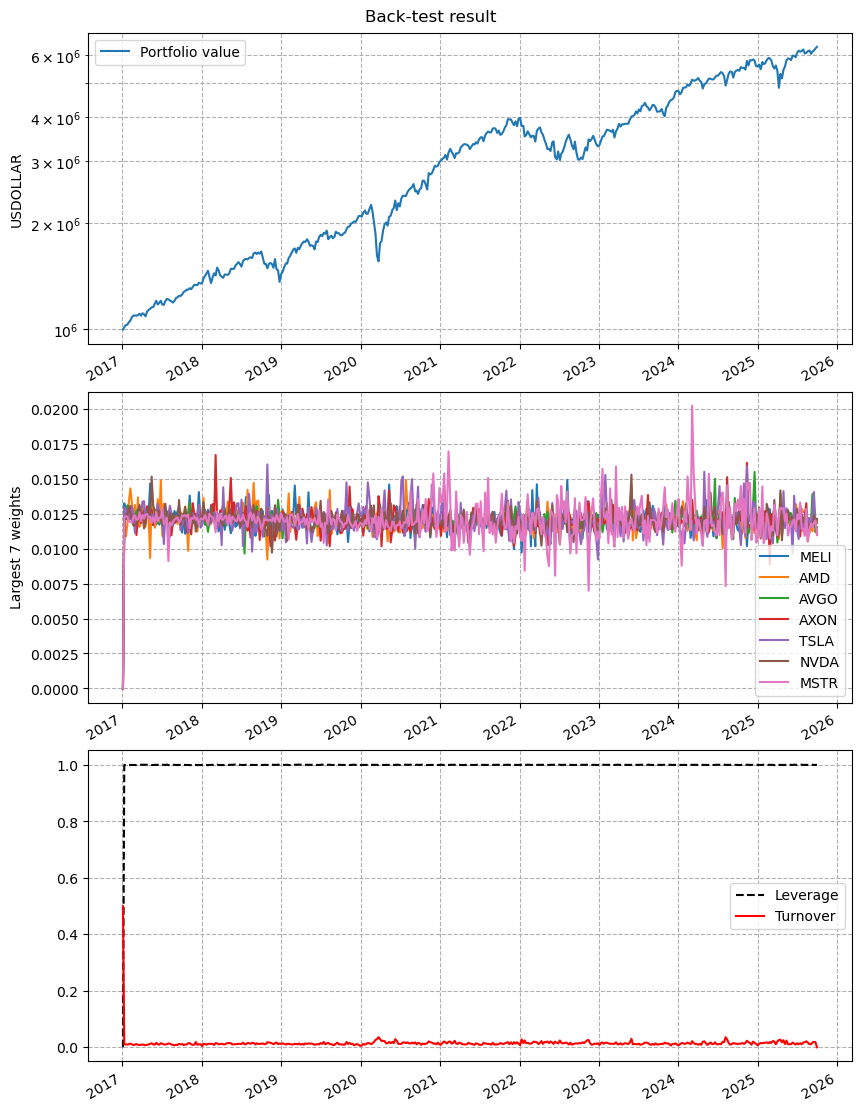

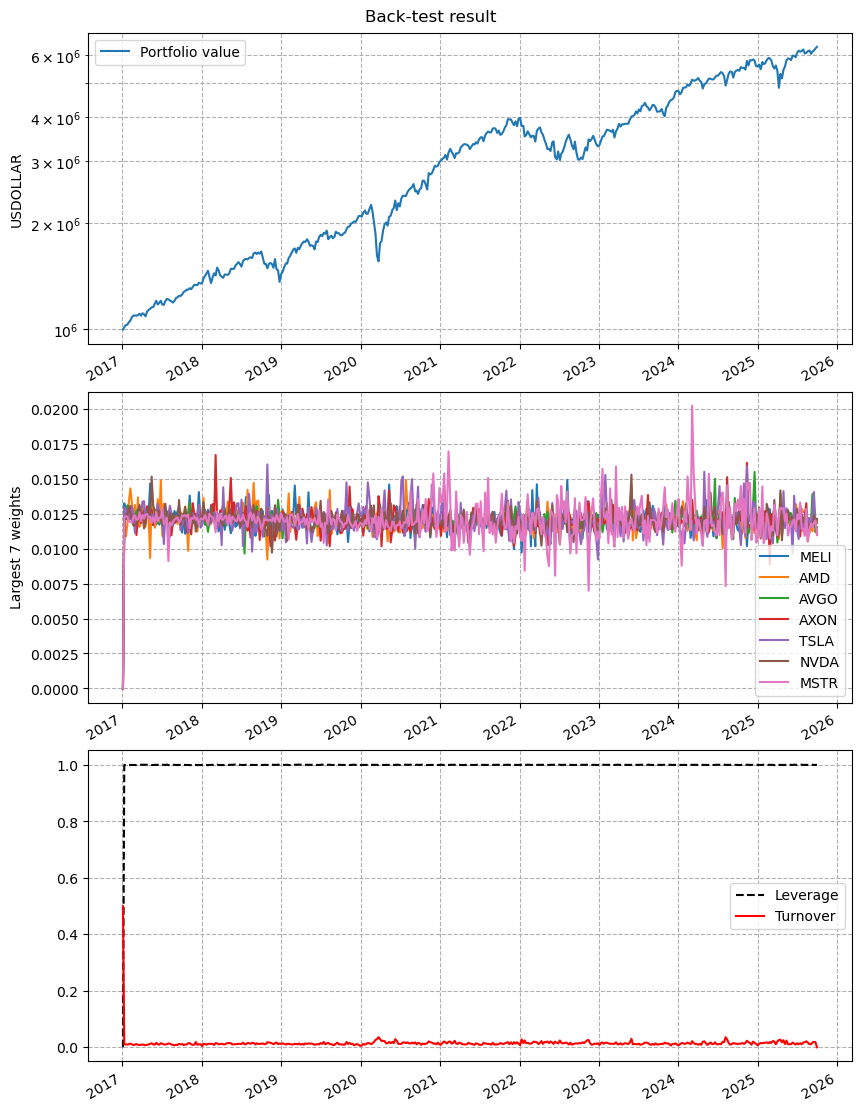

In [21]:
results[1].plot()